# PageRank Algorithm on Spark 

Hi, I'm a beginner on Spark, coding in Python. I was looking for a very simple first project and read multiple explanations of the PageRank algorithm but none that didn't require using the Command Prompt. I hope my attempt, with plentiful explanations, is helpful.

## I The PageRank Theory

Equations and directed graphs below are based on "Data-Intensive Text Processing with MapReduce" textbook by Jimmy Lin and Chris Dyer.  
The PageRank of a page is defined as the probability that the random websurfer will view page p:

$$ Rank(p)=\alpha \frac{1}{GraphNodes} +(1-\alpha)\left(\frac{1}{GraphNodes}\sum_{d \in DanglingNodes}Rank(d)+\sum_{k \in InLinks(p)}\frac{Rank(k)}{OutLinks(k)}\right)$$

with $\alpha$ the random jump factor (probability that the random websurfer visits any page) and $1-\alpha$ the probability he follows a link.

The probability that the random websurfer will arrive from k in the Inlinks of page p to p is $\frac{Rank(k)}{OutLinks(k)}$ and we sum this probability over all inlinks.

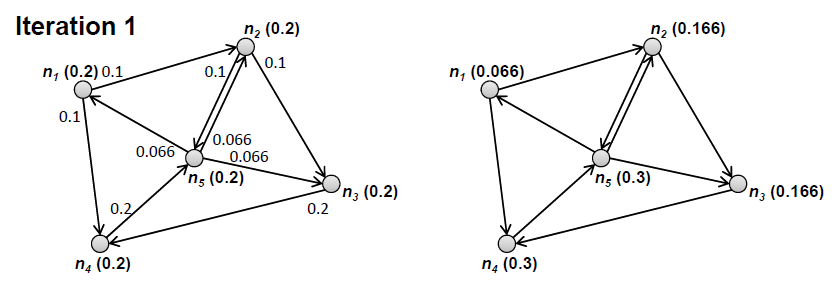

In [3]:
from IPython.display import Image
Image(filename="./Graph.png")

In the Map step, probability mass is distributed along the vertices.  
In the Shuffle and Sort step, probabilities are grouped by destination node.   
In the Reduce step, probabilities from incoming links are summed to update the node's ranking.  


Initially we set $\alpha$ to 0 and implement the directed graph of the book with no dangling nodes.

## II PageRank Python Code Multithreading on Spark

In [1]:
import os
from pyquickhelper.filehelper import remove_folder
import pyspark
from pyspark import SparkContext
from operator import add
import timeit

sc = SparkContext(appName="PythonPageRank")

This section is where a directed graph is created, initially to resemble that of the book.
Other inputs control how many iterations we will do, whether we stop at convergence or impose a limit.

In [8]:
# Section for user inputs

#Build a directed graph which simulates the result of a webcrawler.
L1='l1'
L2='l2'
L3='l3'
L4='l4'
L5='l5'

alpha=0 #random jump factor
maxIter=10 # regardless of convergence will stop at set number of iterations. Beware, 6 iterations take 6 min!
tolerance=0.01 # will stop if successive rank results are within a certain tolerance of each other (convergence).
gchoice='book' # choice of directed graph to test PageRank on: book, dangle or repeat.

I tried to group the computation of dangling node mass and rank mass propagation into one referral function but the assignment to the global variable didn't work in the lambda function so we split into 2 distict functions instead.

In [9]:
# Section for function definitions

def chooseGraph(gtype):
    ''' User selects the type of directed graph to test PageRank on. Choices are 'book', 'dangle' or 'repeat. Returns the graph as a tuple. '''
    if gtype=='book':
        graph = ((L1,(L2,L4)), (L2,(L3,L5)), (L3,(L4,)), (L4,(L5,)), (L5,(L1,L2,L3))) # as in book
    elif gtype=='dangle':
        graph = ((L1,(L2,L4)), (L2,(L3,L5)), (L3,(L4,)), (L4,()), (L5,(L1,L2,L3))) # L4 is dangling
    elif gtype=='repeat':
        # L5 key repeated (the webcrawler could crawl a page twice by mistake.) 
        # The case where a key has different values is purposely not considered. 
        # A crawler can't get different results on the same page.
        graph = ((L1,(L2,L4)), (L2,(L3,L5)), (L3,(L4,)), (L4,(L5,)), (L5,(L1,L2,L3)),(L5,(L1,L2,L3))) 
    else:
        print('Error: Incorrect choice of Graph')
    return graph
            
def referral(urls, rank):
    '''Calculates URL referral weight to the rank of the URLs it references.'''
    urlsNb = len(urls)
    for url in urls:
        yield (url, rank / urlsNb) #this returns a generator (only once iterable), lazy execution
        
def lostMass(urls,rank):
    '''Calculates lost mass for a dangling node.'''
    urlsNb = len(urls)
    if urlsNb==0:
        global pmdn
        pmdn=pmdn+rank #probability mass of dangling node is passed on
        yield pmdn 

We then initiate the parallelization process in Spark.

In [10]:
# Section for initializing the process in Spark
        
DirGraph=chooseGraph(gchoice)
nodenb=len(DirGraph)

nodesRDD = sc.parallelize(DirGraph, nodenb) #splits the problem over as many CPUs as there are nodes

# A webcrawler might get the same link mutliple times as key, so we use distinct
nodesRDD = nodesRDD.distinct()
#nodesRDD.collect() #check

# The same Graph is iterated over multiple times. To improve efficiency we cache the data in memory.
# We use persist() as opposed to cache() so that the level of memory storing is made explicit.
nodesRDD = nodesRDD.persist(pyspark.StorageLevel.MEMORY_ONLY)

Finally we implement the pagerank algorithm.

In [11]:
# Section for PageRank algorithm

startTime = timeit.default_timer() #check algo speed

# Initializes all nodes to a weight of 1/nodenb which is the probability that they are chosen at random.      
ranks = nodesRDD.map(lambda outlinks: (outlinks[0], 1/nodenb))
#ranks.collect()
ranksmem=ranks.lookup(L1)[0] #initialize rank memory for node L1 to check for convergence

for k in range(maxIter): # Calculates and updates URL ranks iteratively

    countIter=k+1 # tracks iterations to reach convergence if "tolerance" parameter breaks the loop
    pmdn=0 # probability mass of dangling nodes
    ranks = nodesRDD.join(ranks)
    
    # calculates dangling nodes' lost mass. genitem:(node,((outlink1, outlink2),rank)).
    pmdn= ranks.flatMap(lambda genitem: lostMass(genitem[1][0], genitem[1][1])).sum()
    # Calculates URL contributions to rank of other URLs. 
    ranks= ranks.flatMap(lambda genitem: referral(genitem[1][0], genitem[1][1]))

    # Re-calculates URL ranks based on neighbor contributions.
    # We use add as opposed to "lambda x, y: x+y" because we read it is faster
    # groupbykey is less efficient (more shuffling of data between CPU) with large databases
    ranks = ranks.reduceByKey(add)
    ranks = ranks.mapValues(lambda rank: alpha*(1/nodenb) + (1-alpha)*(pmdn/nodenb+rank))
    
    # the line below may raise exception: "Randomness of hash of string should be disabled via PYTHONHASHSEED"
    # solution: edit "path" in Windows Environment Variables with a new variable PYTHONHASHSEED and set the value to 0.
    ranksnew=ranks.lookup(L1)[0] 
    if abs(ranksnew-ranksmem)<abs(tolerance): #in case user sets a negative tolerance
        break
    ranksmem=ranksnew
   
finalRanks=ranks.collect()
algoTime = timeit.default_timer() - startTime

# Displaying and results

if countIter==maxIter:
    print("The pagerank algorithm performed the maximum value of {} iterations in {:0.1f} seconds without reaching a level of convergence between successive page rank results of {}. Page ranks are:".format(maxIter, algoTime, tolerance))
else:
    print('With {} iterations in {:0.1f} seconds page rank results have converged with successive results within {} of each other. Page ranks are:'.format(countIter, algoTime, tolerance))

finalRanks #display results

The pagerank algorithm performed the maximum value of 1 iterations in 45.3 seconds without reaching a level of convergence between successive page rank results of 0.01. Page ranks are:


[('l3', 0.2066666666666667),
 ('l2', 0.2066666666666667),
 ('l5', 0.14),
 ('l1', 0.10666666666666666),
 ('l4', 0.34)]

The results found match those in the book at the first and second iteration. For the first iteration (gchoice='book', alpha=0, maxIter=1) you should get:


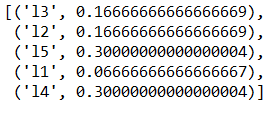

In [4]:
Image(filename="./Book1.png")

Convergence at the 0.01 tolerance level is reached at the 6th iteration. What is remarkable is that the pagerank algorithm converges with so few iterations and also that Spark requires so much time per iteration.

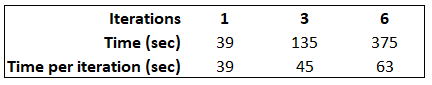

In [5]:
Image(filename="./Speed.png")

Granted the time to map/reduce is predominent for small directed graphs and that fixed cost becomes negligible for large graphs.

You may repeat the algorithm testing with one dangling node (gchoice='dangle', alpha=0, maxIter=1) and verify manually that the first iteration results in the appropriate ranks.

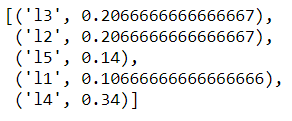

In [6]:
Image(filename="./Dangle1.png")

I hope this helped!